In [71]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt

In [72]:
# the images are in the current directory
IMAGE_DIR = 'Mirai1_Data/Mirai1_0_data_Circle_200'

# List all the feature images and sort them to ensure correct order
feature_images = sorted([img for img in os.listdir(IMAGE_DIR) if img.startswith('X')])
label_images = sorted([img for img in os.listdir(IMAGE_DIR) if img.startswith('Y')])

# Define a custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, feature_images, label_images, transform=None):
        self.feature_images = feature_images
        self.label_images = label_images
        self.transform = transform

    def __len__(self):
        return len(self.feature_images)

    def __getitem__(self, idx):
        feature_img_path = os.path.join(IMAGE_DIR, self.feature_images[idx])
        label_img_path = os.path.join(IMAGE_DIR, self.label_images[idx])

        feature_img = plt.imread(feature_img_path)[:, :, 0]  # Take only the first channel
        label_img = plt.imread(label_img_path)[:, :, 0]      # Take only the first channel

        if self.transform:
            feature_img = self.transform(feature_img)
            label_img = self.transform(label_img)

        return feature_img, label_img


transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = CustomDataset(feature_images, label_images, transform=transform)


In [73]:
print(len(dataset))

200


In [74]:
# Split the dataset into training and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)


In [75]:
data, target = train_dataset[0]
print(data.shape)
print(target.shape)

torch.Size([1, 50, 50])
torch.Size([1, 50, 50])


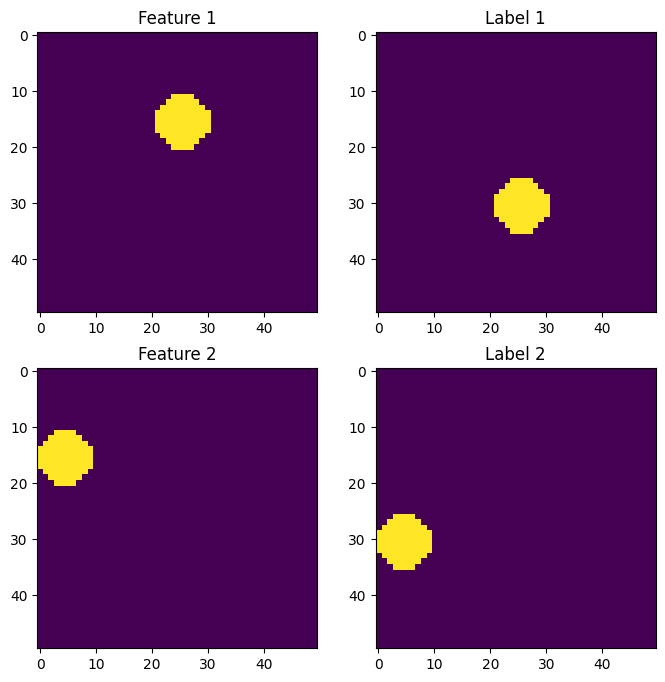

In [76]:
# Visualize 2 random images and their labels
def visualize_samples(loader, num_samples=2):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples*4))
    for i in range(num_samples):
        axes[i, 0].imshow(images[i].numpy().transpose(1, 2, 0))
        axes[i, 0].set_title(f"Feature {i+1}")

        axes[i, 1].imshow(labels[i].numpy().transpose(1, 2, 0))
        axes[i, 1].set_title(f"Label {i+1}")
    plt.show()

visualize_samples(train_loader)

In [77]:
#for training of any model
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    corrects = 0.0
    for batch in train_loader:
        data, target = batch
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == target.data)
    return total_loss / len(train_loader.dataset)#, corrects.double() / len(train_loader.dataset)

In [78]:
#for validation dataset
def validate(model, valid_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    corrects = 0.0
    with torch.no_grad():
        for batch in valid_loader:
            data, target = batch
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item() * data.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == target.data)
    return total_loss / len(valid_loader.dataset)#, corrects.double() / len(valid_loader.dataset)

In [10]:
#Benchmark Model
class BenchmarkModel(nn.Module):
    def __init__(self):
        super(BenchmarkModel, self).__init__()
        self.fc1 = nn.Linear(50*50, 1000)  # Example hidden layer
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 50*50)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(x.size(0), 1, 50, 50)  # Reshape back to image format

In [80]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = BenchmarkModel().to(device)
# criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=3)

model = EnhancedBenchmarkModel().to(device)
criterion = nn.MSELoss()  # Mean Square Error Loss for regression tasks
optimizer = torch.optim.SGD(model.parameters(), lr=3, weight_decay=1e-4, momentum=0.9)


In [81]:
# Lists to collect losses and accuracies for each epoch
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

total_epochs = 0
total_time = 0

Epoch 1: Train Loss: 0.0307, Validation Loss: 0.0303
Epoch 2: Train Loss: 0.0299, Validation Loss: 0.0297
Epoch 3: Train Loss: 0.0293, Validation Loss: 0.0291
Epoch 4: Train Loss: 0.0287, Validation Loss: 0.0285
Epoch 5: Train Loss: 0.0280, Validation Loss: 0.0280
Epoch 6: Train Loss: 0.0274, Validation Loss: 0.0274
Epoch 7: Train Loss: 0.0267, Validation Loss: 0.0268
Epoch 8: Train Loss: 0.0260, Validation Loss: 0.0261
Epoch 9: Train Loss: 0.0253, Validation Loss: 0.0255
Epoch 10: Train Loss: 0.0245, Validation Loss: 0.0248
Epoch 11: Train Loss: 0.0237, Validation Loss: 0.0240
Epoch 12: Train Loss: 0.0227, Validation Loss: 0.0232
Epoch 13: Train Loss: 0.0218, Validation Loss: 0.0223
Epoch 14: Train Loss: 0.0208, Validation Loss: 0.0214
Epoch 15: Train Loss: 0.0198, Validation Loss: 0.0206
Epoch 16: Train Loss: 0.0188, Validation Loss: 0.0197
Epoch 17: Train Loss: 0.0178, Validation Loss: 0.0188
Epoch 18: Train Loss: 0.0169, Validation Loss: 0.0180
Epoch 19: Train Loss: 0.0161, Validat

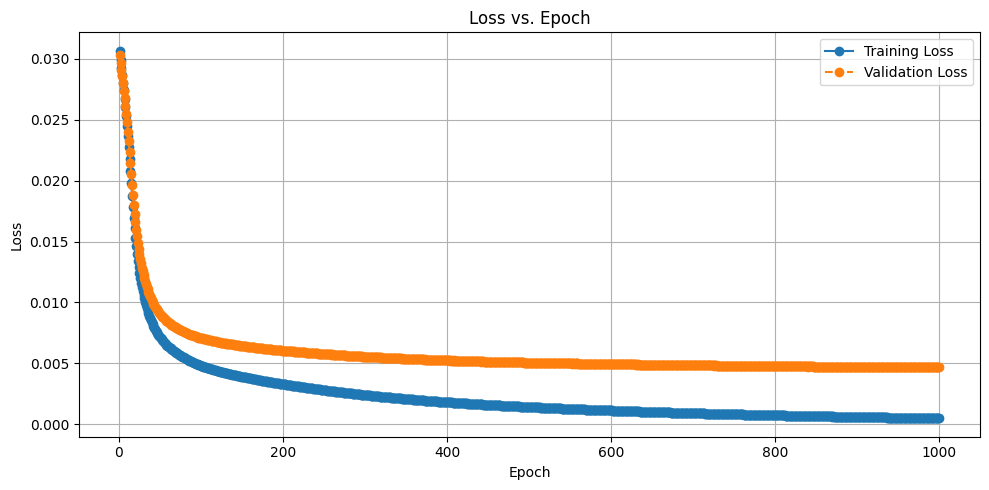

In [14]:
optimizer = torch.optim.SGD(model.parameters(), lr=3)
for epoch in range(1, 1001):
    start_time = time.time()

    train_loss = train(model, train_loader, criterion, optimizer, device)
    valid_loss = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    elapsed_time = time.time() - start_time
    total_time += elapsed_time

    print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(10, 5))

# Loss plots
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


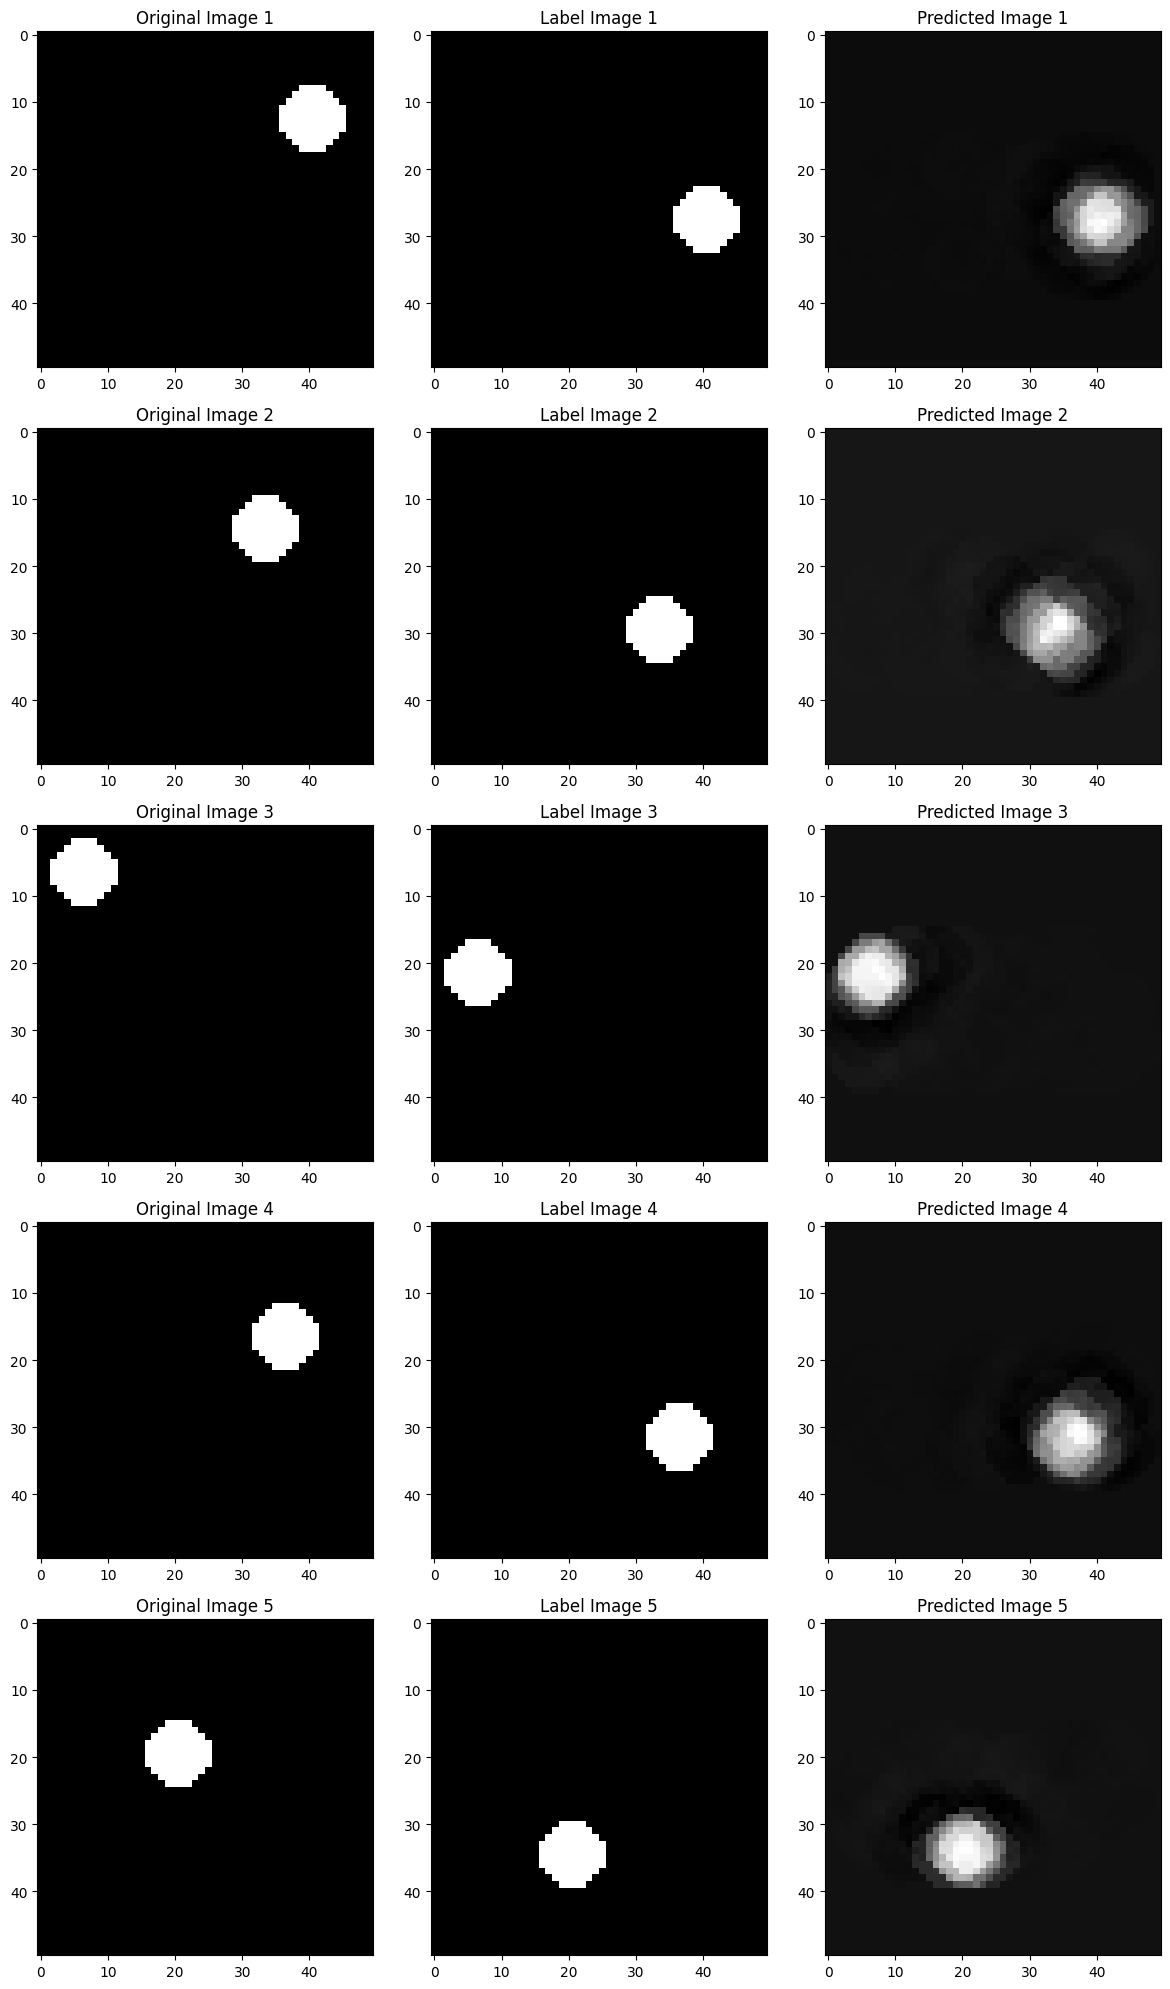

In [54]:
IMAGE_DIR = 'Mirai1_Data/Mirai1_0_data_Circle_200'
def visualize_predictions(model, loader, num_samples=5):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images.to(device))

    # Convert tensors to numpy arrays for visualization
    images = images.numpy()
    labels = labels.numpy()
    predictions = outputs.cpu().numpy()

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples*4))
    for i in range(num_samples):
        axes[i, 0].imshow(images[i].squeeze(), cmap='gray')
        axes[i, 0].set_title(f"Original Image {i+1}")

        axes[i, 1].imshow(labels[i].squeeze(), cmap='gray')
        axes[i, 1].set_title(f"Label Image {i+1}")

        axes[i, 2].imshow(predictions[i].squeeze(), cmap='gray')
        axes[i, 2].set_title(f"Predicted Image {i+1}")

    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, test_loader)


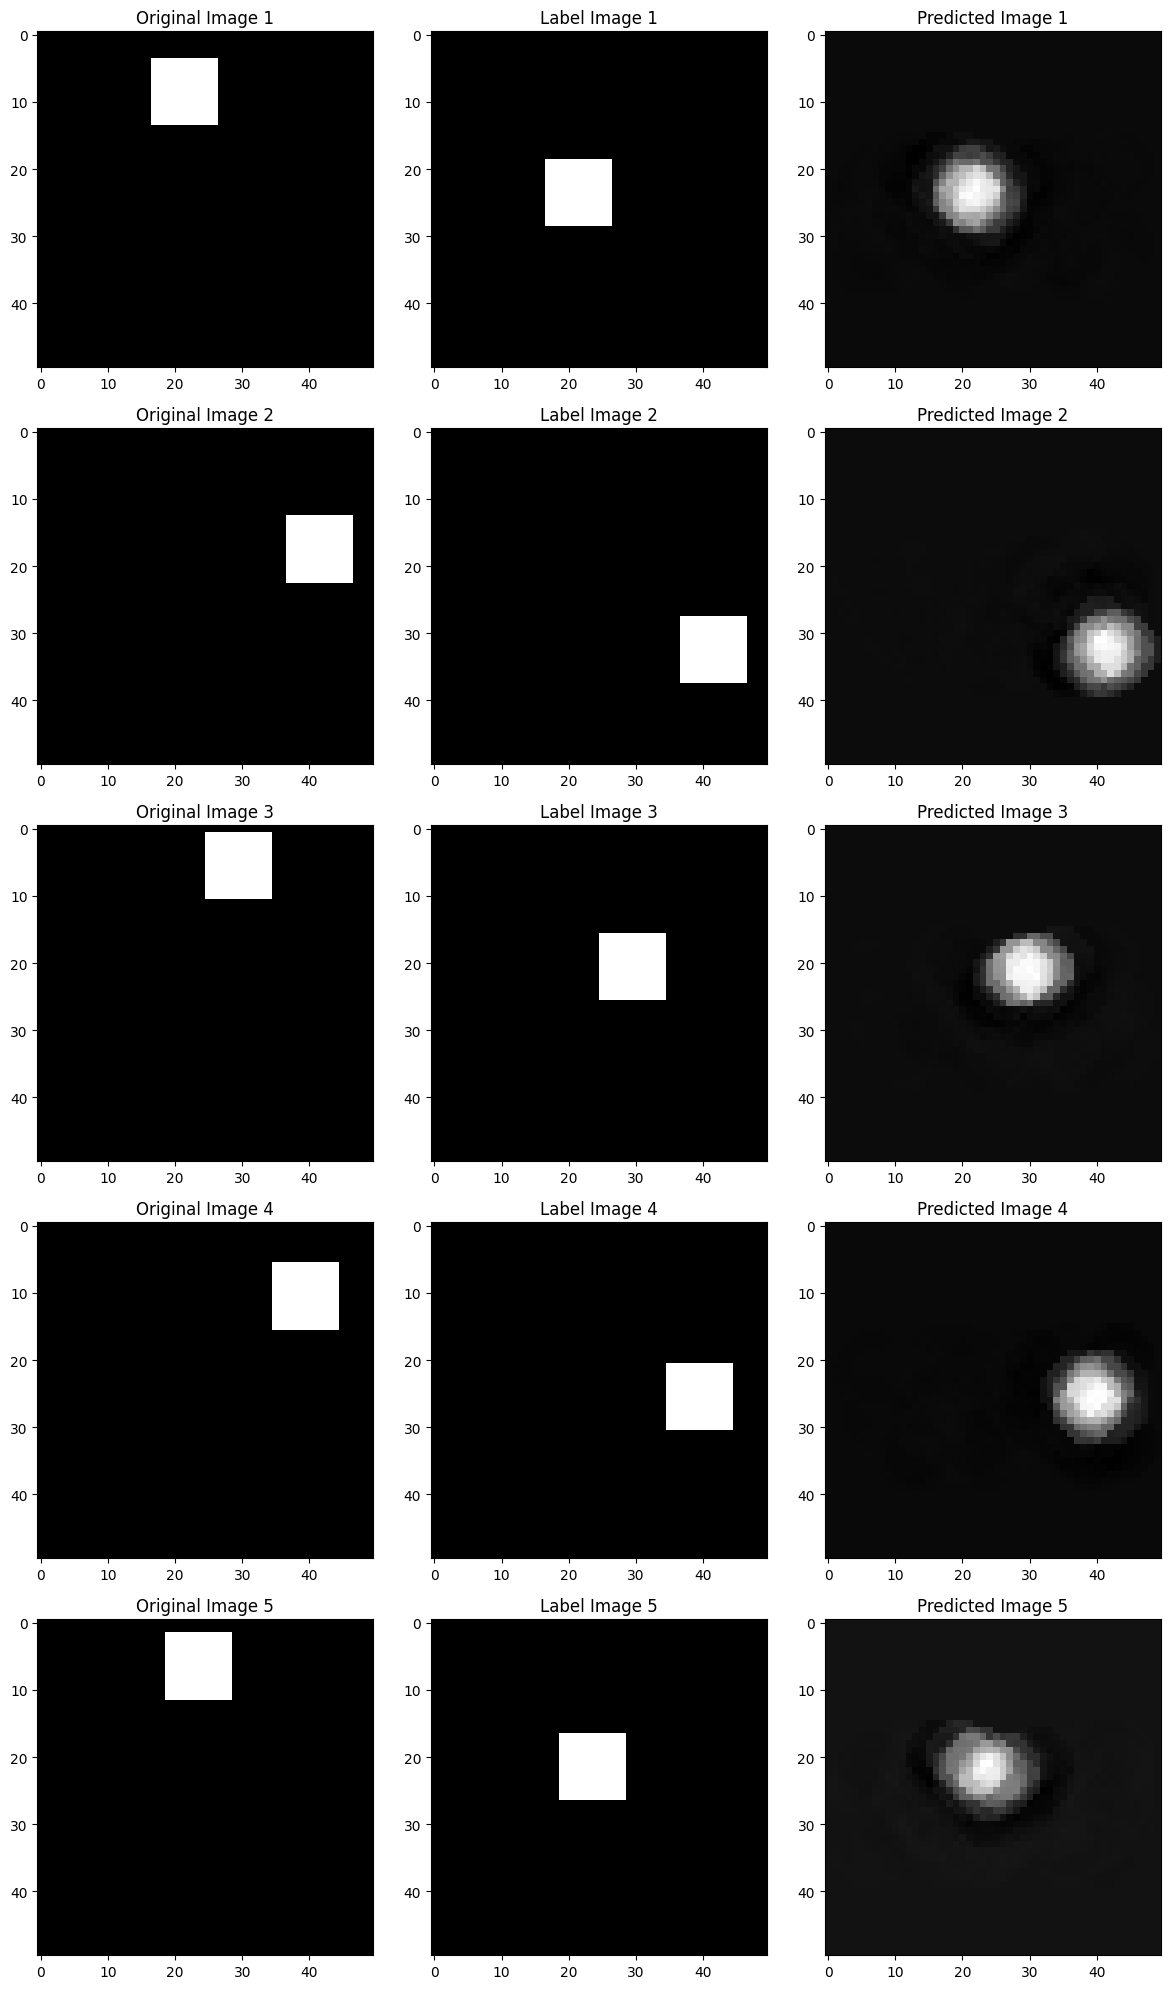

In [55]:
# the images are in the "Square" directory
IMAGE_DIR = 'Mirai1_Data/Mirai1_0_data_square_8'

# List all the feature images and sort them to ensure correct order
feature_images = sorted([img for img in os.listdir(IMAGE_DIR) if img.startswith('X')])
label_images = sorted([img for img in os.listdir(IMAGE_DIR) if img.startswith('Y')])

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset_2 = CustomDataset(feature_images, label_images, transform=transform)
test_loader_2 = torch.utils.data.DataLoader(dataset_2, batch_size=8, shuffle=True)

visualize_predictions(model, test_loader_2)

In [79]:
class EnhancedBenchmarkModel(nn.Module):
    def __init__(self):
        super(EnhancedBenchmarkModel, self).__init__()
        self.fc1 = nn.Linear(50*50, 1000)
        # self.dropout1 = nn.Dropout(0.2)  # 50% dropout
        self.fc2 = nn.Linear(1000, 1000)
        # self.dropout2 = nn.Dropout(0.2)  # 50% dropout
        self.fc3 = nn.Linear(1000, 50*50)

        # He Initialization
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        # x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        # x = self.dropout2(x)
        x = self.fc3(x)
        return x.view(x.size(0), 1, 50, 50)



Epoch 1: Train Loss: 0.0386, Validation Loss: 0.0294
Epoch 2: Train Loss: 0.0283, Validation Loss: 0.0280
Epoch 3: Train Loss: 0.0268, Validation Loss: 0.0270
Epoch 4: Train Loss: 0.0254, Validation Loss: 0.0258
Epoch 5: Train Loss: 0.0235, Validation Loss: 0.0241
Epoch 6: Train Loss: 0.0211, Validation Loss: 0.0221
Epoch 7: Train Loss: 0.0184, Validation Loss: 0.0199
Epoch 8: Train Loss: 0.0160, Validation Loss: 0.0180
Epoch 9: Train Loss: 0.0142, Validation Loss: 0.0166
Epoch 10: Train Loss: 0.0128, Validation Loss: 0.0154
Epoch 11: Train Loss: 0.0116, Validation Loss: 0.0145
Epoch 12: Train Loss: 0.0108, Validation Loss: 0.0136
Epoch 13: Train Loss: 0.0100, Validation Loss: 0.0130
Epoch 14: Train Loss: 0.0094, Validation Loss: 0.0124
Epoch 15: Train Loss: 0.0089, Validation Loss: 0.0119
Epoch 16: Train Loss: 0.0085, Validation Loss: 0.0115
Epoch 17: Train Loss: 0.0081, Validation Loss: 0.0111
Epoch 18: Train Loss: 0.0078, Validation Loss: 0.0108
Epoch 19: Train Loss: 0.0075, Validat

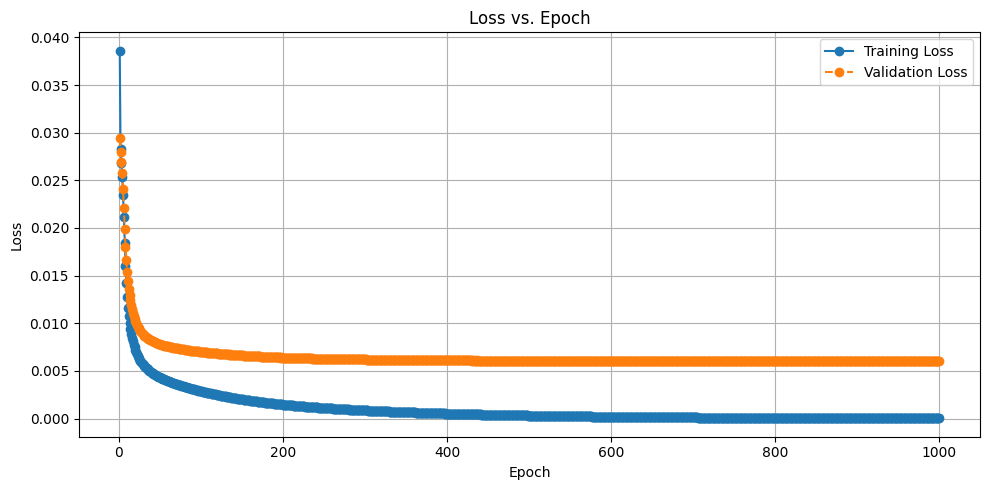

In [82]:
optimizer = torch.optim.SGD(model.parameters(), lr=3, momentum=0.9)

for epoch in range(1, 1001):
    start_time = time.time()

    train_loss = train(model, train_loader, criterion, optimizer, device)
    valid_loss = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    elapsed_time = time.time() - start_time
    total_time += elapsed_time

    print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

    total_epochs += 1

# Print total training time
print(f"Total training time: {total_time:.2f} seconds")

# Plotting
plt.figure(figsize=(10, 5))

# Loss plots
plt.plot(range(1, total_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, total_epochs+1), valid_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
